# Homework 7: Decision Trees, Bagging, Random Forests
Part1 Decision Tree questions

Part2 Application to the real data

Part 3 Multiclass metrics

## Part 1 (3 pt) Basic elements of decision trees
**Write the code line that calculates the result.**

---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q 1 (1 pt)** Given that 10 objects have reached a decision tree node, where 8 of them belong to class $C_1$, and 2 belong to class $C_2,$ calculate the impurity of this node, using entropy.

In [2]:
# Probabilities of each class
c1 = 8 / 10
c2 = 2 / 10

# Calculate the entropy
# Entropy = - sum(p_i * log2(p_i))
entropy = -c1 * np.log2(c1) - c2 * np.log2(c2)

print("Using entropy, the impurity of this node is: ", entropy)

Using entropy, the impurity of this node is:  0.7219280948873623


**Q2 (1 pt)** Additionally, it is known that the node from the previous task is not a leaf, and it is possible to split it in such a way that all objects of class $C_1$ end up in the left subtree and class $C_2$ objects end up in the right subtree. Calculate the (non-truncated) information gain criterion:

$$
Q = H(V) - \frac{|V_L|}{|V|}H(V_L) - \frac{|V_R|}{|V|}H(V_R).
$$
Now, $H(V)$ is calculated using Gini index:
$$
H(V) = \sum_{k=1}^C p_k(1-p_k),
$$
where $C$ is the number of classes (two in our case).

In [3]:
# Calculate H(V), Gini Index
gini = 1 - c1**2 - c2**2

# Calculate Gini Index for left subtree and right subtree
gini_left = 0   # 0 * (1 - 0) + 1 * (1 - 1), all objects of class C1 end up in the left subtree
gini_right = 0  # 1 * (1 - 1) + 0 * (1 - 0), all objects of class C2 end up in the right subtree

# Calculate the information gain
q = gini - (8/10) * gini_left - (2/10) * gini_right

print("Information gain criterion, using Gini Index, is: ", q)

Information gain criterion, using Gini Index, is:  0.31999999999999984


**Q3 (1 pt)** During the tree construction using MAE metric for impurity (a regression problem is being solved), a leaf node is formed with 10 objects, and the values of the target variable for these objects are as follows: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]. What will be the model's predictions for these objects?

In [4]:
# Target values
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

# MAE metric calculation
prediction = np.median(target_values)

# Model's prediction
print("Model prediction: ", prediction)

# The model's prediction for a leaf node is the median of the target values for the objects in that node.
# We proved that H(V) is median of the data in Problems 14 (2/29 Class)

Model prediction:  38.5


## Part 2: (12 pt) Bagging and Random Forest
We well work with the dataset from HW6. Just run all the cells below to cteate data for training and evaluation.

---

In [5]:
#m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Members.csv',index_col='MemberID')
#m.head()

In [6]:
#claims=pd.read_csv(path+'Claims_Y1.csv',index_col='MemberID')
claims=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/Claims.csv',index_col='MemberID')
#claims.head()

In [7]:
#days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2=pd.read_csv('https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/DaysInHospital_Y2.csv',index_col='MemberID')
#days2.head()

In [8]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

In [9]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

In [10]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
#X.head()

In [11]:
X = X.join(m.Sex)
#X.head()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [15]:
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

In [16]:
transform.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='infrequent_if_exist'),
                                 ['Sex'])])

In [17]:
X_train_transformed = pd.DataFrame(transform.transform(X_train),columns=transform.get_feature_names_out())
X_train_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,1.0,0.0,0.0,1.0,0.0,50.0
1,0.0,0.0,0.0,0.0,0.0,20.0
2,0.0,0.0,0.0,0.0,0.0,70.0
3,0.0,1.0,0.0,0.0,0.0,50.0
4,1.0,0.0,0.0,1.0,0.0,70.0


In [18]:
X_test_transformed = pd.DataFrame(transform.transform(X_test),columns=transform.get_feature_names_out())
X_test_transformed.head()

,OneHot__Sex_M,OneHot__Sex_nan,remainder__ClaimsTruncated,remainder__CharlsonIndex,remainder__LengthOfStay,remainder__AgeAtFirstClaim
0,0.0,0.0,0.0,0.0,3.0,30.0
1,0.0,0.0,1.0,1.0,1.0,80.0
2,1.0,0.0,0.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,60.0
4,0.0,0.0,0.0,1.0,0.0,80.0


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split

**Q4 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_leaf` for the `DecisionTreeClassifier`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the F1-score as the criterion (parameter `scoring` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the decision tree with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
# Create a dictionary with possible values to iterate over
# Running multiple ranges for both parameters showed that the grid search settles
# to be around 8-9 max_depth and 15-20 min_samples_leaf
# Thus, max_depth is a range from 1 to 15
# and min_samples_leaf is a range from 1 to 25
# Running with both being range of 1 to 50, but it was performance and time heavy
# Maximum depth is 16 because 2^16 = 65,536 with only 53,000 samples present in the dataset
# X is around 53,000 samples (76039 in days2, 70% is training data)
param_grid = {
    'max_depth': range(1, 15),
    'min_samples_leaf': range(1, 25)
}

In [22]:
# Use grid search with cross-validation using the F1-score as the criterion
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(1, 25)},
             scoring='f1')

In [23]:
# Choose the pair of values that provides the best quality
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'max_depth': 8, 'min_samples_leaf': 20}


In [24]:
# Train the decision tree with the selected hyperparameters on the full training set
best_tree = DecisionTreeClassifier(max_depth = best_params['max_depth'], min_samples_leaf = best_params['min_samples_leaf'])
best_tree.fit(X_train_transformed, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

In [25]:
# Get predictions
y_pred = best_tree.predict(X_test_transformed)

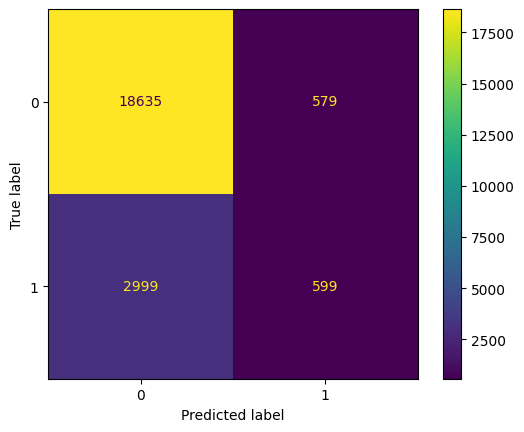

In [26]:
# Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [27]:
recall_score(y_test, y_pred)

0.16648137854363534

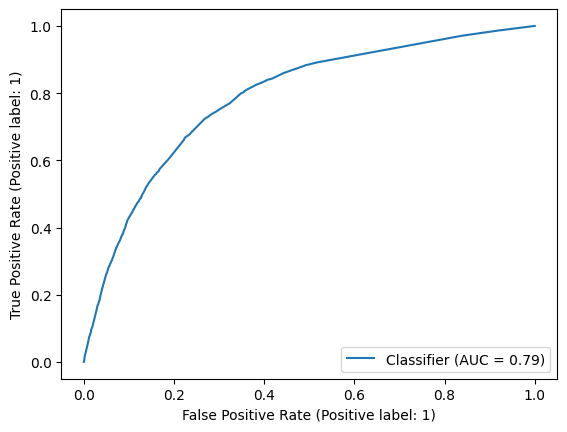

In [28]:
RocCurveDisplay.from_predictions(y_test, best_tree.predict_proba(X_test_transformed)[:,1])

**Q5 (3 pt)** Train [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with 50 trees on the training set, use parameter `max_samples=0.9`. Estimate the quality using metrics from the previous question.

In [29]:
# Create Bagging Classifier with 50 trees and max_samples of 0.9
# Fit it to training data
clf_bag = BaggingClassifier(n_estimators=50, max_samples=0.9)
clf_bag.fit(X_train_transformed, y_train)

BaggingClassifier(max_samples=0.9, n_estimators=50)

In [30]:
# Get predictions on test data for Bagging Classifier
y_pred_bag = clf_bag.predict(X_test_transformed)

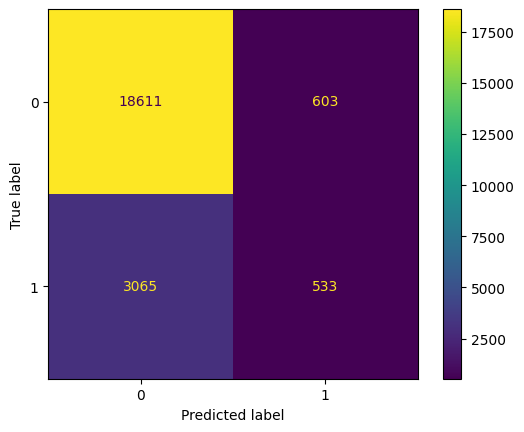

In [31]:
# Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bag)

In [32]:
recall_score(y_test, y_pred_bag)

0.1481378543635353

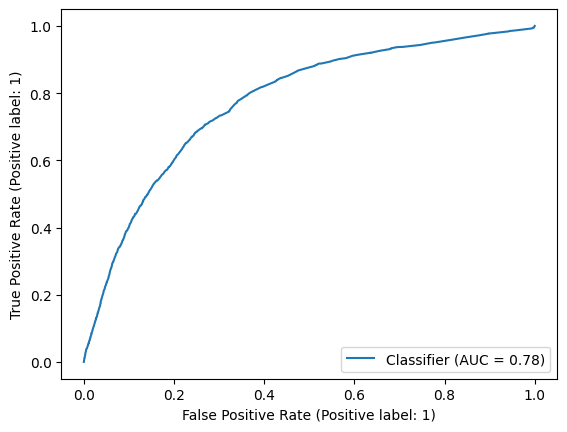

In [33]:
RocCurveDisplay.from_predictions(y_test, clf_bag.predict_proba(X_test_transformed)[:,1])

**Q6 (4 pt)** On the training set, find the optimal values for the hyperparameters `max_depth` and `min_samples_split` for the `Random Forest`. To do this:

(a) Create a dictionary with possible values to iterate over.

(b) Use grid search with cross-validation (we don't use validation set) using the f1-score as the criterion (parameter `scoring="f1"` in GridSearchCV).

(c) Choose the pair of values that provides the best quality.

Train the random forest with the selected hyperparameters on the full training set. Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.

Which of these models worked better?

In [34]:
clf_rf = RandomForestClassifier(class_weight='balanced')

In [35]:
clf_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [36]:
# Create a dictionary with possible values to iterate over
# These parameters were chosen because the range from 1 to 15/20/25 took too long to evaluate
# Maximum depth is 16 because 2^16 = 65,536 with only 53,000 samples present in the dataset
# Lower numbers of max_depth have been disregarded as they have never been hit
# max_depth of 16 is ignored as it is unlikely to be used.
# X is around 53,000 samples (76039 in days2, 70% is training data)
# 2,3 step is introduced to imporve performance of finding best model for Random Forest
param_grid = {
    'max_depth': [5, 7, 10, 12, 15],
    'min_samples_split': [5, 7, 10, 12, 15, 17, 20]
}

In [37]:
# Use grid search with cross-validation using the F1-score as the criterion
# (Takes around 4 minutes to go through param_grid)
grid_search = GridSearchCV(clf_rf, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [5, 7, 10, 12, 15],
                         'min_samples_split': [5, 7, 10, 12, 15, 17, 20]},
             scoring='f1')

In [38]:
# Choose the pair of values that provides the best quality
best_params = grid_search.best_params_
print("Best parameters: ", best_params)

Best parameters:  {'max_depth': 10, 'min_samples_split': 12}


In [39]:
# Train the random forest with the selected hyperparameters on the full training set
best_clf_rf = RandomForestClassifier(class_weight='balanced', max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
best_clf_rf.fit(X_train_transformed, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=12)

In [40]:
# Get predictions
y_pred_rf = best_clf_rf.predict(X_test_transformed)

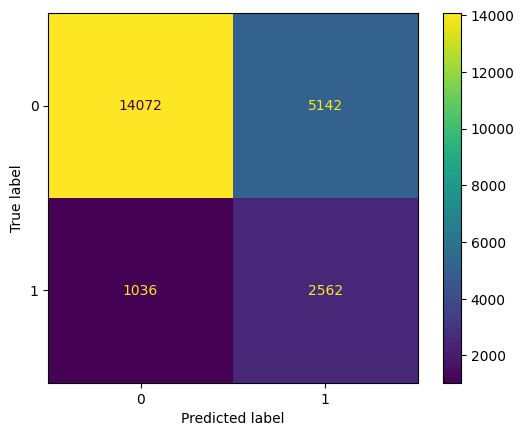

In [41]:
# Evaluate the classification quality on the test set using Confusion Matrix and metrics recall, and auc_roc.
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

In [42]:
recall_score(y_test, y_pred_rf)

0.7120622568093385

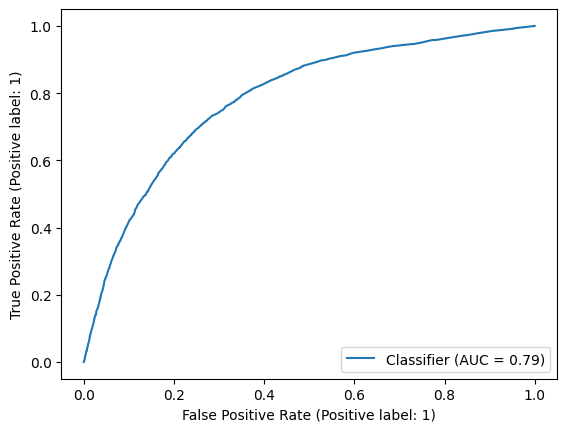

In [43]:
RocCurveDisplay.from_predictions(y_test, best_clf_rf.predict_proba(X_test_transformed)[:,1])

Random Forest Classifier has worked significantly better than the rest of the model, hitting a recall score of around 71.21% compared to around 14.81% of Bagging Classifier and around 16.65% of Decision Tree Classifier. AUC_ROC has not changed between the models. Random Forest Classifier, however, gave fewer False Negative and more False Positives. It classified more True Positives than the other models, but have classified less True Negatives. Possible fix is to adjust other parameters to decrease misclassifications.

**Q7 (1 pt)** For the best model report the most relevant features, parameter `feature_importances_`

In [44]:
# Get feature importances and names from X columns
features_relevant = best_clf_rf.feature_importances_
names = X_train_transformed.columns

# Create pandas Series and sort it
series = pd.Series(features_relevant, index=names).sort_values(ascending=False)

# show series
series

remainder__LengthOfStay       0.585056
remainder__AgeAtFirstClaim    0.153161
remainder__CharlsonIndex      0.086620
OneHot__Sex_nan               0.080773
remainder__ClaimsTruncated    0.080589
OneHot__Sex_M                 0.013801
dtype: float64

## Part 3.
**Q8 (5 pt)** Given the confusion matrix, write the expression that calculates macro- and micro- f1-score. For macro-averaging we calculate f1 for every class and then average. For micro-averaging we average TP, FP, FN and then calculate metrics.

**Write the code that calculates f1-score using the numbers below**

In [45]:
np.random.seed(42)
y_target = np.random.randint(0, 3, 20)
y_pred = np.random.randint(0, 3, 20)

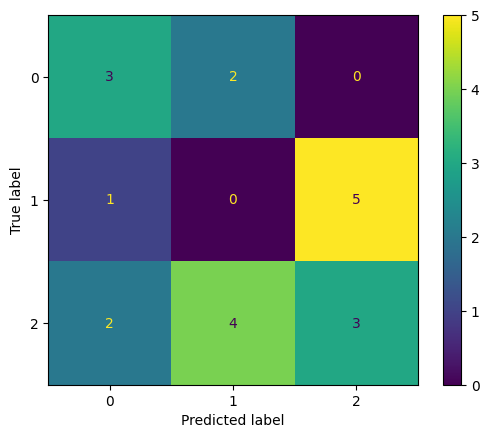

In [46]:
ConfusionMatrixDisplay.from_predictions(y_target, y_pred)

In [47]:
# Calculate TP, FP, FN for Class 0
TP_0 = 3
FP_0 = 1 + 2
FN_0 = 2 + 0

# Calculate Precision and Recall for Class 0
precision_0 = TP_0 / (TP_0 + FP_0)
recall_0 = TP_0 / (TP_0 + FN_0)

# Calculate F1 for Class 0
F1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)

In [48]:
# Calculate TP, FP, FN for Class 1
TP_1 = 0
FP_1 = 2 + 4
FN_1 = 1 + 5

# Calculate Precision and Recall for Class 1
precision_1 = TP_1 / (TP_1 + FP_1)
recall_1 = TP_1 / (TP_1 + FN_1)

# Calculate F1 for Class 1
F1_1 = 0 # 2 * (precision_1 * recall_1) / (precision_1 + recall_1)

In [49]:
# Calculate TP, FP, FN for Class 2
TP_2 = 3
FP_2 = 5 + 0
FN_2 = 2 + 4

# Calculate Precision and Recall for Class 1
precision_2 = TP_2 / (TP_2 + FP_2)
recall_2 = TP_2 / (TP_2 + FN_2)

# Calculate F1 for Class 1
F1_2 = 2 * (precision_2 * recall_2) / (precision_2 + recall_2)

In [50]:
# Macro F1 is average of each class F1
f1_macro = (F1_0 + F1_1 + F1_2) / 3

In [51]:
from sklearn.metrics import make_scorer, f1_score

In [52]:
assert np.abs(f1_macro-f1_score(y_target, y_pred, average="macro")) < 1e-5

In [53]:
# Show manually calculated F1-macro
f1_macro

0.29946524064171126

In [54]:
# Show automatically calculated F1-macro
f1_score(y_target, y_pred, average="macro")

0.29946524064171126

In [55]:
# Calculate total TP, FP, and FN
TP_total = TP_0 + TP_1 + TP_2
FP_total = FP_0 + FP_1 + FP_2
FN_total = FN_0 + FN_1 + FN_2

# Calculate Precision and Recall using combined TP, FP, and FN
precision_micro = TP_total / (TP_total + FP_total)
recall_micro = TP_total / (TP_total + FN_total)

In [56]:
# Use F1 formula with precision and recall calculating using combined TP, FP, FN
f1_micro = 2 * (precision_micro * recall_micro) / (precision_micro + recall_micro)

In [57]:
assert np.abs(f1_micro-f1_score(y_target, y_pred, average="micro")) < 1e-5

In [58]:
# Show manually calculated F1-micro
f1_micro

0.3

In [59]:
# Show automatically calculated F1-micro
f1_score(y_target, y_pred, average="micro")

0.3